In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
DIR = "/content/drive/MyDrive/MLOPS-40"
os.chdir(DIR)

Mounted at /content/drive


In [6]:
# 1. Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


🔍 Iniciando búsqueda de hiperparámetros con GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ GridSearchCV finalizado en 43.91 segundos
Mejores parámetros encontrados:
{'regressor__estimator__learning_rate': 0.1, 'regressor__estimator__max_depth': 5, 'regressor__estimator__n_estimators': 200, 'regressor__estimator__subsample': 0.8}

💾 Pipeline guardado como 'xgb_tetouan_pipeline.pkl'

📊 Resultados del modelo XGBoost Pipeline:

--- Zone 1 Power Consumption ---
MAE : 1135.225
RMSE: 1523.851
R²  : 0.954


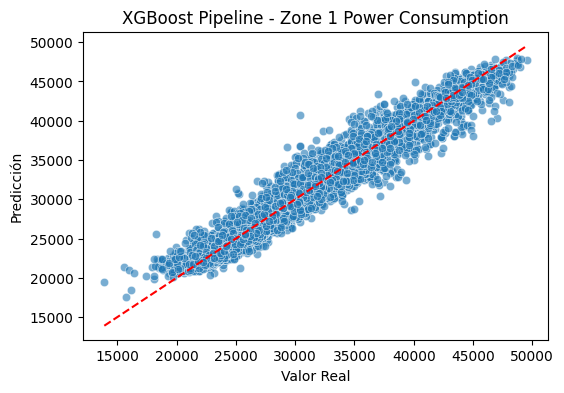


--- Zone 2  Power Consumption ---
MAE : 923.324
RMSE: 1231.576
R²  : 0.944


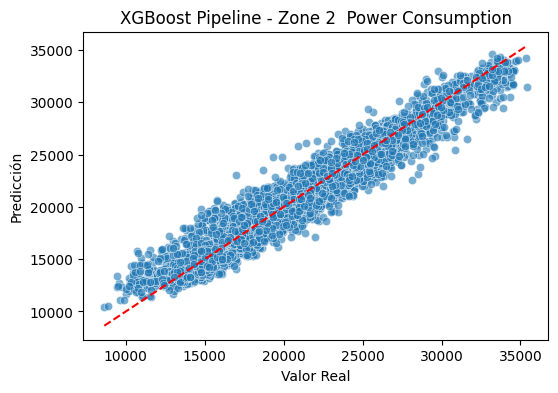


--- Zone 3  Power Consumption ---
MAE : 658.229
RMSE: 921.819
R²  : 0.976


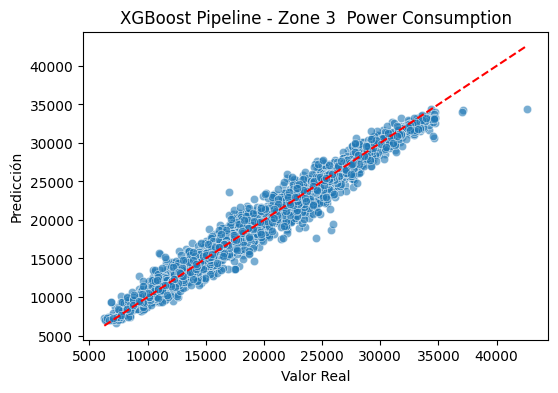


📈 Resumen de métricas:
                                    MAE         RMSE        R2
Zone 1 Power Consumption   1135.225472  1523.851346  0.954017
Zone 2  Power Consumption   923.324027  1231.575717  0.943880
Zone 3  Power Consumption   658.228649   921.818863  0.976317

🔁 Validación cruzada del pipeline completo...
R² promedio (CV): 0.826 ± 0.044


In [7]:
df = pd.read_csv("power_tetouan_city_clean.csv")

# Se asume que ya separaste la fecha en hour, day, month, year
# y que el dataset incluye las 3 zonas como variables objetivo
target_cols = [
    'Zone 1 Power Consumption',
    'Zone 2  Power Consumption',
    'Zone 3  Power Consumption'
]

X = df.drop(columns=target_cols)
Y = df[target_cols]

# ===========================================
# 3. División de datos en train/test
# ===========================================
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# ===========================================
# 4. Preprocesamiento automático
# ===========================================
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

# Pipeline para variables numéricas
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas (si existieran)
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinación de ambos tipos de columnas
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# ===========================================
# 5. Definir modelo base con MultiOutputRegressor
# ===========================================
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

multi_xgb = MultiOutputRegressor(xgb_reg)

# ===========================================
# 6. Pipeline completo
# ===========================================
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', multi_xgb)
])

# ===========================================
# 7. Definir espacio de hiperparámetros para GridSearch
# ===========================================
xgb_param_grid = {
    'regressor__estimator__n_estimators': [100, 200],
    'regressor__estimator__max_depth': [3, 5],
    'regressor__estimator__learning_rate': [0.05, 0.1],
    'regressor__estimator__subsample': [0.8, 1.0]
}

# ===========================================
# 8. Búsqueda de hiperparámetros con GridSearchCV
# ===========================================
print("\n🔍 Iniciando búsqueda de hiperparámetros con GridSearchCV...")
start = time.time()

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, Y_train)
end = time.time()

print(f"\n✅ GridSearchCV finalizado en {end - start:.2f} segundos")
print("Mejores parámetros encontrados:")
print(grid.best_params_)

# Guardar el mejor pipeline
best_pipeline = grid.best_estimator_
joblib.dump(best_pipeline, "xgb_tetouan_pipeline.pkl")
print("\n💾 Pipeline guardado como 'xgb_tetouan_pipeline.pkl'")

# ===========================================
# 9. Evaluación del modelo
# ===========================================
Y_pred = best_pipeline.predict(X_test)
Y_pred = pd.DataFrame(Y_pred, columns=Y_test.columns, index=Y_test.index)

def evaluate_model(y_true, y_pred, model_name="Modelo"):
    print(f"\n📊 Resultados del modelo {model_name}:")
    metrics = {}
    for zone in y_true.columns:
        mae = mean_absolute_error(y_true[zone], y_pred[zone])
        rmse = np.sqrt(mean_squared_error(y_true[zone], y_pred[zone]))
        r2 = r2_score(y_true[zone], y_pred[zone])
        metrics[zone] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"\n--- {zone} ---")
        print(f"MAE : {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"R²  : {r2:.3f}")

        # Gráfico Real vs Predicho
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=y_true[zone], y=y_pred[zone], alpha=0.6)
        plt.plot(
            [y_true[zone].min(), y_true[zone].max()],
            [y_true[zone].min(), y_true[zone].max()],
            'r--'
        )
        plt.title(f'{model_name} - {zone}')
        plt.xlabel('Valor Real')
        plt.ylabel('Predicción')
        plt.show()
    return pd.DataFrame(metrics).T

results_df = evaluate_model(Y_test, Y_pred, "XGBoost Pipeline")
print("\n📈 Resumen de métricas:\n", results_df)

# ===========================================
# 10. Validación cruzada adicional (opcional)
# ===========================================
print("\n🔁 Validación cruzada del pipeline completo...")
cv_scores = cross_val_score(best_pipeline, X, Y, cv=5, scoring='r2', n_jobs=-1)
print(f"R² promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")